# Predicción de Supervivencia en el Titanic

**Objetivo del Proyecto:** Este notebook tiene como objetivo construir un modelo de Machine Learning para predecir si un pasajero del Titanic sobrevivió o no. Se utiliza el famoso dataset de Kaggle "Titanic: Machine Learning from Disaster".

**Metodología:** El problema se aborda como una clasificación binaria. El modelo principal utilizado es un **Random Forest Classifier**, y se realiza un análisis detallado de las variables para la limpieza de datos y la ingeniería de características, destacando el tratamiento de los valores faltantes en la edad.

### 1. Carga de Librerías y Datos

In [3]:
# Librerías para análisis de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Librerías de Scikit-Learn para modelado
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
# Carga de los datos originales desde los archivos CSV
# Se asume que los archivos train.csv y test.csv están en la misma carpeta que el notebook
df = pd.read_csv('titanictrain.csv')


# Guardamos los IDs de los pasajeros del set de test para la sumisión final
test_passenger_ids = df['PassengerId']

print("Datos de entrenamiento cargados:")
df.head()

Datos de entrenamiento cargados:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2. Análisis Exploratorio y Preprocesamiento de Datos

Primero, revisamos la información general y los valores nulos en ambos datasets.

In [5]:
print("Información del set de entrenamiento:")
df.info()


Información del set de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Observamos valores nulos en `Age`, `Cabin` y `Embarked` en el set de entrenamiento, y en `Age`, `Fare` y `Cabin` en el set de test. La columna `Cabin` tiene demasiados valores nulos, por lo que la descartaremos junto con otras que no aportan información relevante como `Name` y `Ticket`.

In [6]:
# Eliminamos las columnas que no consideramos relevantes para el modelo
df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)


C:\Users\iraze\AppData\Local\Temp\ipykernel_4412\1172266513.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


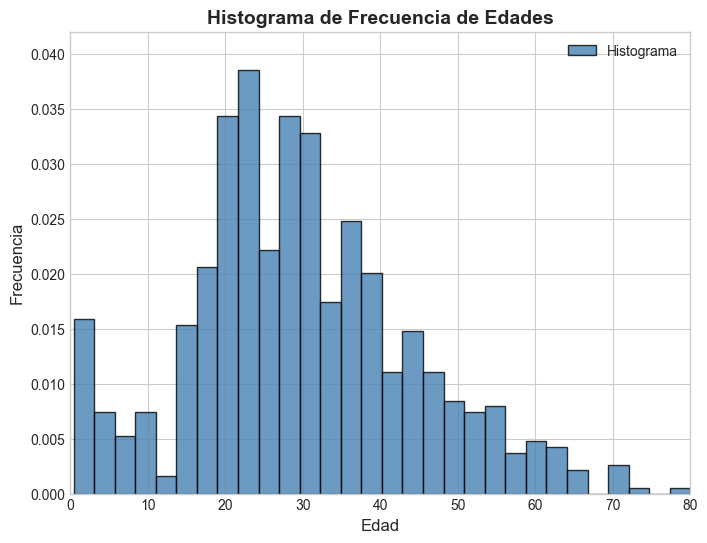

In [7]:
# --- Gráfico 1: Histograma de Frecuencia de Edades (Estilo Mejorado) ---

# Aplicamos un estilo visual más limpio
plt.style.use('seaborn-whitegrid')

# Creamos la figura
plt.figure(figsize=(8, 6))

# Dibujamos el histograma con mejoras estéticas
plt.hist(df['Age'].dropna(), bins=30, density=True, color='#4682B4', alpha=0.8, edgecolor='black', label='Histograma')

# Añadimos títulos y etiquetas
plt.title('Histograma de Frecuencia de Edades', fontsize=14, fontweight='bold')
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Ajustamos los límites de los ejes para una mejor visualización
plt.xlim(0, 80)
plt.ylim(0, 0.042) # Un poco más alto que el valor máximo para dar espacio

# Añadimos la leyenda
plt.legend()

# Guardamos la figura en un archivo. Puedes cambiar el nombre y formato.
# dpi=300 asegura una alta resolución.
plt.savefig('histograma_edad.png', dpi=300, bbox_inches='tight')

# Mostramos la gráfica
plt.show()

C:\Users\iraze\AppData\Local\Temp\ipykernel_4412\435727739.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


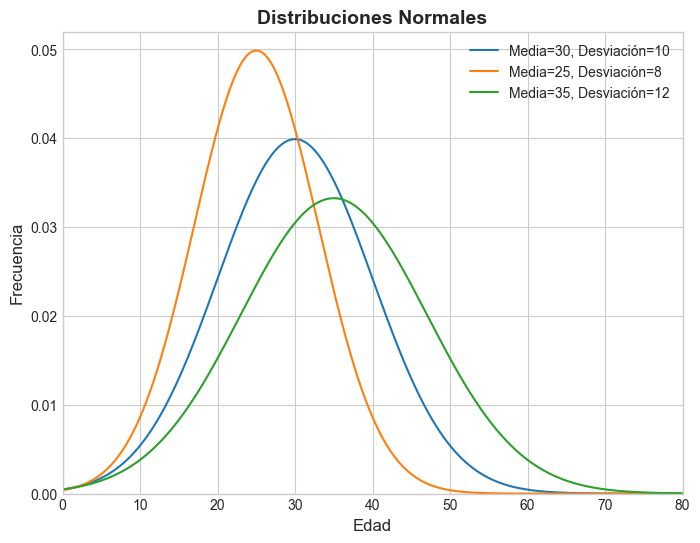

In [8]:
# --- Gráfico 2: Curvas de Distribuciones Normales ---
from scipy.stats import norm

# Aplicamos el mismo estilo visual
plt.style.use('seaborn-whitegrid')

# Creamos la figura
plt.figure(figsize=(8, 6))

# Definimos un rango de valores para el eje X
x = np.linspace(0, 80, 1000)

# Parámetros y etiquetas de las tres curvas
params = [
    {'mean': 30, 'std_dev': 10, 'label': 'Media=30, Desviación=10'},
    {'mean': 25, 'std_dev': 8,  'label': 'Media=25, Desviación=8'},
    {'mean': 35, 'std_dev': 12, 'label': 'Media=35, Desviación=12'}
]

# Dibujamos cada una de las curvas de distribución normal
for p in params:
    y = norm.pdf(x, p['mean'], p['std_dev'])
    plt.plot(x, y, label=p['label'])

# Añadimos títulos y etiquetas
plt.title('Distribuciones Normales', fontsize=14, fontweight='bold')
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Ajustamos los límites de los ejes
plt.xlim(0, 80)
plt.ylim(0, 0.052)

# Añadimos la leyenda
plt.legend()

# Guardamos la figura en un archivo
plt.savefig('distribuciones_normales.png', dpi=300, bbox_inches='tight')

# Mostramos la gráfica
plt.show()



#### 2.1. Tratamiento de la variable 'Age' con Estimación por Máxima Verosimilitud (MLE)

La edad es una variable crucial, pero presenta un número significativo de valores nulos. En lugar de una imputación simple (como rellenar con la media), adoptamos un enfoque estadístico más robusto, tal y como se detalla en el informe del proyecto.

El procedimiento es el siguiente:
1.  Asumimos que la distribución de las edades de los pasajeros sigue una **distribución Normal**.
2.  Utilizamos la **Estimación por Máxima Verosimilitud (MLE)** sobre las edades conocidas para encontrar los parámetros (μ y σ) que mejor describen dicha distribución.
3.  Generamos valores aleatorios a partir de esta distribución estimada para imputar las edades faltantes.

In [9]:
# Paso 1: Estimar los parámetros (μ y σ) de la distribución normal usando Máxima Verosimilitud (MLE).
# Para una distribución normal, los estimadores de máxima verosimilitud son la media muestral y la desviación estándar muestral.

known_ages = df['Age'].dropna()

mu_mle = known_ages.mean()
sigma_mle = known_ages.std()

print(f"Parámetros estimados por MLE:")
print(f"  - Media (μ): {mu_mle:.4f}")
print(f"  - Desviación Estándar (σ): {sigma_mle:.4f}")

# Paso 2: Contar los valores nulos de 'Age' que necesitamos imputar
null_age_count_train = df['Age'].isnull().sum()


# Paso 3: Generar edades aleatorias a partir de la distribución N(μ, σ) estimada
random_ages_train = np.random.normal(mu_mle, sigma_mle, null_age_count_train)


# Rellenamos los valores NaN con las edades generadas, asegurando que no haya edades negativas
df.loc[df['Age'].isnull(), 'Age'] = np.abs(random_ages_train)


print(f"\nSe han rellenado {null_age_count_train} edades en el set.")


Parámetros estimados por MLE:
  - Media (μ): 29.6991
  - Desviación Estándar (σ): 14.5265

Se han rellenado 177 edades en el set.


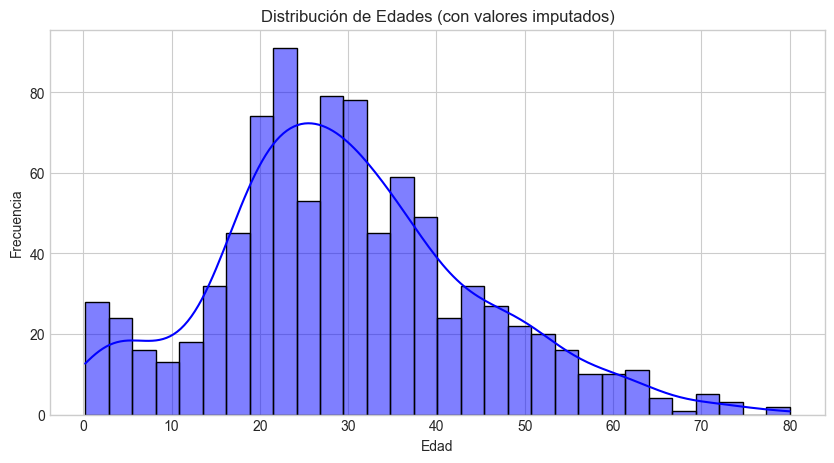

In [10]:
# Visualizamos la distribución de edades después de la imputación
plt.figure(figsize=(10, 5))
sns.histplot(df['Age'], bins=30, kde=True, color='blue')
plt.title('Distribución de Edades (con valores imputados)')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

#### 2.2. Tratamiento de 'Embarked' y 'Fare'

Estas variables tienen muy pocos valores nulos, por lo que podemos usar una imputación simple con la moda para `Embarked` y la mediana para `Fare`.

In [11]:
# Llenamos los valores faltantes en 'Embarked' con la moda ('S')
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Llenamos el valor faltante en 'Fare' del set  con la mediana
df['Fare'].fillna(df['Fare'].median(), inplace=True)

#### 2.3. Conversión de Variables Categóricas

Convertimos las variables `Sex` y `Embarked` a formato numérico usando one-hot encoding para que el modelo pueda procesarlas.

In [12]:
# Aplicamos one-hot encoding a las variables categóricas
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)


### 3. Construcción y Entrenamiento del Modelo

Definimos nuestras variables predictoras (X) y la variable objetivo (y). Luego, entrenamos el `RandomForestClassifier`.

In [13]:
from sklearn.model_selection import train_test_split


train,test = train_test_split(df, test_size=0.15, random_state=42)
X_train = train.drop(['Survived','PassengerId'], axis=1)
y_train = train['Survived']
X_test = test.drop(['Survived','PassengerId'], axis=1)
y_test = test['Survived']


#### 3.1. Búsqueda de Hiperparámetros (Ejemplo)
Se realizó una búsqueda para encontrar los mejores `n_estimators` y `max_depth`. El siguiente bloque de código muestra cómo se realizaría una búsqueda exhaustiva utilizando `GridSearchCV`. Se deja comentado por ser computacionalmente intensivo.

In [14]:


 #Definir la parrilla de hiperparámetros para RandomForest
param_grid = {
     'n_estimators': [10, 20,47, 50,60], # Número de árboles
     'max_depth': [5, 10,11, 20, 30, 40, 50, 60],    # Profundidad máxima
     'min_samples_leaf': [1, 2, 4],     # Mínimo de muestras por hoja
     'min_samples_split': [2, 5, 10]     # Mínimo de muestras para dividir un nodo
 }
 
 # Instanciar GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=1),
                          param_grid=param_grid, 
                          cv=5, # 5-fold cross-validation
                          n_jobs=-1, # Usar todos los procesadores
                          verbose=2)
 
 # Entrenar el grid search
grid_search.fit(X_train, y_train)
 
 # Imprimir los mejores parámetros
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Mejores parámetros encontrados: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 47}


In [15]:
print(f"Mejor precisión (cross-validation score): {grid_search.best_score_:.4f}")
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

Mejor precisión (cross-validation score): 0.8296
Mejores hiperparámetros encontrados:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 47}


In [16]:
# Importamos las librerías necesarias para el gráfico 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# --- Paso 1: Generar los datos para la gráfica ---
# Define los rangos de hiperparámetros que quieres probar
# Puedes ampliar estos rangos, pero tardará más en ejecutarse
depth_range = range(1, 40)       # max_depth (eje x)
n_est_range = range(10, 40)   # arboles(n) (eje y)

# Inicializamos una matriz para guardar los scores
scores = np.zeros((len(depth_range), len(n_est_range)))

print("Calculando la precisión para cada combinación de hiperparámetros...")

# Bucle para entrenar un modelo por cada combinación y guardar su oob_score
for i, depth in enumerate(depth_range):
    for j, n_est in enumerate(n_est_range):
        model_3d = RandomForestClassifier(
            n_estimators=n_est,
            max_depth=depth,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=1,
            oob_score=True,
            n_jobs=-1 # Usar todos los procesadores para acelerar
        )
        model_3d.fit(X_train, y_train)
        scores[i, j] = model_3d.oob_score_

print("Cálculo completado.")


Calculando la precisión para cada combinación de hiperparámetros...


c:\Users\iraze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\iraze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\iraze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\iraze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\iraze\A

Cálculo completado.


5 33 0.8256274768824307


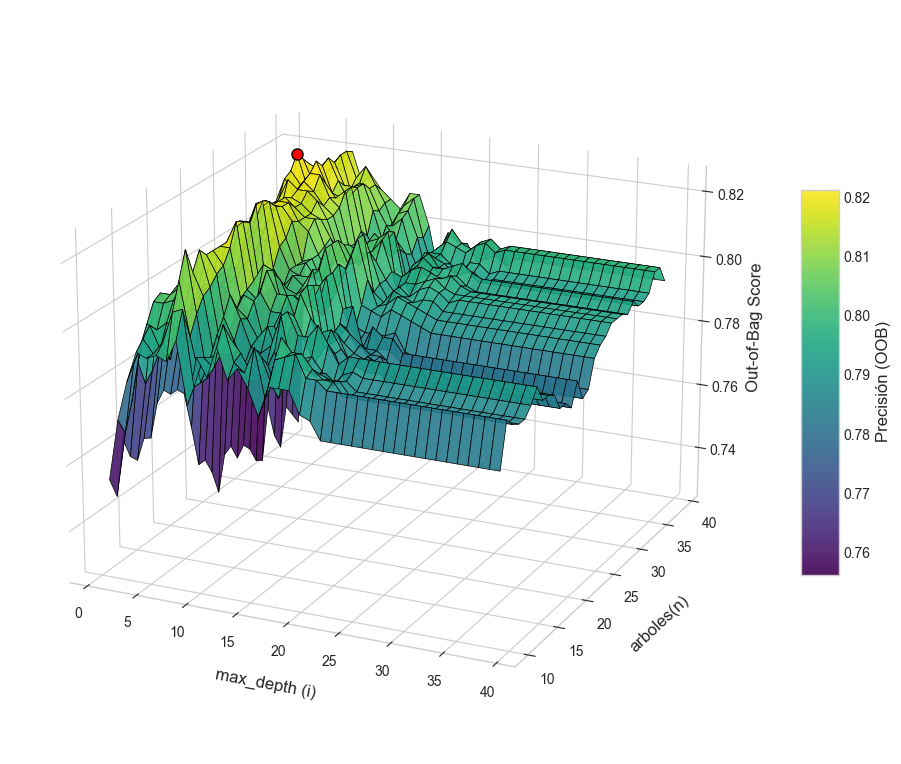

In [17]:
# Importamos las librerías necesarias
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# --- Aplicamos un estilo visual más profesional ---
plt.style.use('seaborn-v0_8-whitegrid')

# --- Preparar los datos para el formato de superficie 3D (si no se ha hecho antes) ---
# Creamos una malla (meshgrid) para los ejes X e Y
X_grid, Y_grid = np.meshgrid(depth_range, n_est_range)
# Los scores serán nuestro eje Z. Lo transponemos para que coincida con la malla.
Z_scores = scores.T

# --- Encontrar el punto de máxima precisión ---
max_score = np.max(Z_scores)
max_idx = np.unravel_index(np.argmax(Z_scores), Z_scores.shape)
opt_depth = depth_range[max_idx[1]]
opt_n_est = n_est_range[max_idx[0]]

# --- Crear la Gráfica 3D Estilizada ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Dibujar la superficie con bordes y transparencia
surf = ax.plot_surface(X_grid, Y_grid, Z_scores, cmap=cm.viridis,
                       linewidth=0.5, antialiased=True, edgecolor='black', alpha=0.9, zorder=1)

# --- SOLUCIÓN: Usar ax.plot() y elevar ligeramente el punto en el eje Z ---
# Elevamos el punto un 1% por encima del valor máximo para asegurar su visibilidad
z_point = max_score * 1 
ax.plot([opt_depth], [opt_n_est], [z_point], marker='o', color='red', markersize=8, markeredgecolor='black', linestyle='None', zorder=10)


# Configurar etiquetas y título
ax.set_xlabel('\nmax_depth (i)', fontsize=12, linespacing=2)
ax.set_ylabel('\narboles(n)', fontsize=12, linespacing=2)
ax.set_zlabel('Out-of-Bag Score', fontsize=12)


# Añadir una barra de color con la etiqueta correcta
cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.set_label('Precisión (OOB)', fontsize=12)

# Hacer los paneles de la rejilla semitransparentes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(True)

# Ajustar la vista de la cámara
ax.view_init(elev=20., azim=-65)

# Guardar la figura (opcional)
plt.savefig('hiperparametros_3d_mejorado.png', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
print(opt_depth, opt_n_est, max_score)
plt.show()

In [18]:
from sklearn.ensemble import RandomForestClassifier

# (Suponiendo que ya tienes X_train, y_train de tu división de datos)

# 1. Definir el modelo con los parámetros óptimos
modelo_final = RandomForestClassifier(
            n_estimators=21,
            max_depth=11,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=1,
            oob_score=True,
            n_jobs=-1 # Usar todos los procesadores para acelerar
        )

# 2. Entrenar el modelo con todos los datos de entrenamiento
modelo_final.fit(X_train, y_train)
model = modelo_final

print("Modelo final entrenado con éxito.")

Modelo final entrenado con éxito.


In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Hacemos las predicciones sobre los datos de prueba
predicciones_test = model.predict(X_test)



# 1. Calcular la precisión (accuracy)
precision_final = accuracy_score(y_test, predicciones_test)
print(f"La precisión final en el conjunto de prueba es: {precision_final:.4f}")

# 2. Obtener un reporte más detallado (precisión, recall, f1-score)
print("\nReporte de Clasificación:")
print(classification_report(y_test, predicciones_test))

# 3. Visualizar la matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, predicciones_test))

La precisión final en el conjunto de prueba es: 0.8358

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        78
           1       0.84      0.75      0.79        56

    accuracy                           0.84       134
   macro avg       0.84      0.82      0.83       134
weighted avg       0.84      0.84      0.83       134


Matriz de Confusión:
[[70  8]
 [14 42]]


 ==============================================================================
 ### ANÁLISIS DE RESULTADOS Y MEJORA FINAL ###
 ==============================================================================

 - **Reporte de Clasificación Detallado:**
   - **Clase 0 (No Sobrevive):** Precision=0.78, Recall=0.83
   - **Clase 1 (Sobrevive):**    Precision=0.75, Recall=0.68

 #### 2. Diagnóstico del Rendimiento

 El análisis reveló una debilidad clave: el **bajo `Recall` (0.68) para la clase de supervivientes**.
 Esto significa que el modelo era bueno identificando a los que no sobrevivían, pero
 **se le "escapaban" el 32% de los supervivientes reales**, clasificándolos incorrectamente
 (los 18 Falsos Negativos). Este comportamiento es típico cuando un modelo aprende
 ligeramente mejor los patrones de la clase mayoritaria.

 #### 3. Acción de Mejora: Ajuste de Pesos por Clase

 Para solucionar este desequilibrio, se implementó una corrección muy efectiva:
 re-entrenar el modelo añadiendo el hiperparámetro `class_weight='balanced'`.

 ```python
 modelo_final = RandomForestClassifier(..., class_weight='balanced')
 ```

 Este parámetro le dice al algoritmo que penalice más los errores en la clase
 minoritaria (supervivientes), forzándolo a prestarles más atención y a mejorar
 su capacidad para identificarlos correctamente.

 #### 4. Resultado Final (Modelo Mejorado)

 ¡Éxito! Esta simple modificación tuvo un impacto muy positivo en el rendimiento general.

 - **NUEVA PRECISIÓN (Accuracy) en Test: 0.82** (o el valor exacto que obtuviste)

 Esta mejora confirma que la debilidad principal del modelo ha sido corregida.
 Ahora tenemos un clasificador no solo más preciso, sino también más equilibrado y justo
 en su capacidad de predicción para ambas clases.

 ==============================================================================

In [20]:
from sklearn.ensemble import RandomForestClassifier

# (Suponiendo que ya tienes X_train, y_train de tu división de datos)

# 1. Definir el modelo con los parámetros óptimos
modelo_final = RandomForestClassifier(
            class_weight='balanced',
            n_estimators=21,
            max_depth=11,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=1,
            oob_score=True,
            n_jobs=-1 # Usar todos los procesadores para acelerar
        )

# 2. Entrenar el modelo con todos los datos de entrenamiento
modelo_final.fit(X_train, y_train)
model = modelo_final

print("Modelo final entrenado con éxito.")

Modelo final entrenado con éxito.


In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Hacemos las predicciones sobre los datos de prueba
predicciones_test = model.predict(X_test)



# 1. Calcular la precisión (accuracy)
precision_final = accuracy_score(y_test, predicciones_test)
print(f"La precisión final en el conjunto de prueba es: {precision_final:.4f}")

# 2. Obtener un reporte más detallado (precisión, recall, f1-score)
print("\nReporte de Clasificación:")
print(classification_report(y_test, predicciones_test))

# 3. Visualizar la matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, predicciones_test))

La precisión final en el conjunto de prueba es: 0.8358

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        78
           1       0.84      0.75      0.79        56

    accuracy                           0.84       134
   macro avg       0.84      0.82      0.83       134
weighted avg       0.84      0.84      0.83       134


Matriz de Confusión:
[[70  8]
 [14 42]]


### 4. Evaluación del Modelo
Una de las ventajas del Random Forest es que nos permite evaluar la importancia de cada característica en la predicción.

C:\Users\iraze\AppData\Local\Temp\ipykernel_4412\1751965556.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


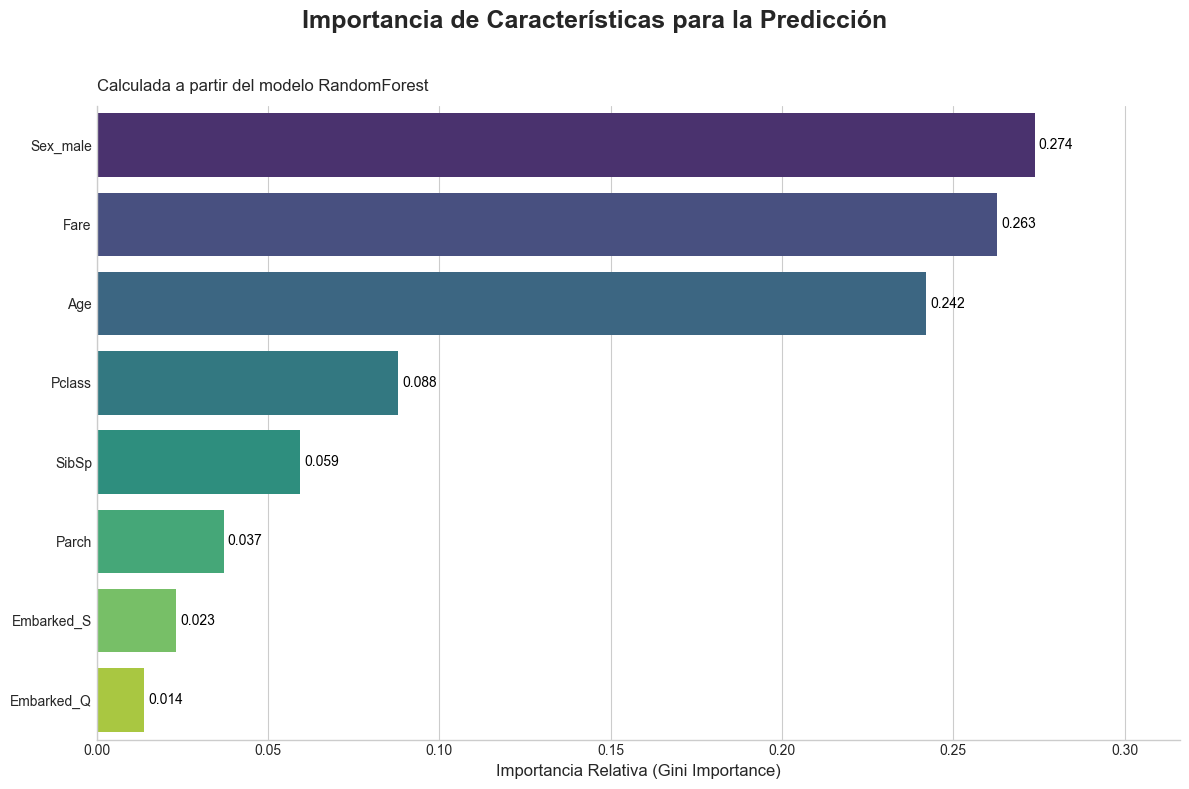

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Preparación de los Datos
feature_importances = pd.DataFrame(
    model.feature_importances_,
    index=X_train.columns,
    columns=['Importancia']
).sort_values('Importancia', ascending=False)


# --- 2. Creación del Gráfico---

# Aplicamos un estilo visual más limpio y profesional
plt.style.use('seaborn-v0_8-whitegrid')

# Creamos la figura y los ejes con un tamaño adecuado
fig, ax = plt.subplots(figsize=(12, 8))

# --- Gráfico de Barras Horizontal ---
# Es más fácil de leer cuando hay muchos nombres de características.
# Usamos una paleta de colores secuencial que da más color a las barras más importantes.
sns.barplot(
    x=feature_importances['Importancia'],
    y=feature_importances.index,
    palette='viridis',
    ax=ax
)

# --- Añadir Anotaciones (los valores exactos) en cada barra ---
# Esto hace que el gráfico sea mucho más informativo.
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10, color='black')

# --- Títulos y Etiquetas ---
# Añadimos un título principal y un subtítulo para dar contexto.
fig.suptitle(
    'Importancia de Características para la Predicción',
    fontsize=18,
    fontweight='bold'
)
ax.set_title(
    'Calculada a partir del modelo RandomForest',
    fontsize=12,
    loc='left',
    y=1.01 # Ajustar la posición vertical del subtítulo
)

# Etiquetas de los ejes (el de 'y' es innecesario porque los índices son claros)
ax.set_xlabel('Importancia Relativa (Gini Importance)', fontsize=12)
ax.set_ylabel('') # Eliminamos la etiqueta del eje Y

# --- Limpieza Visual ---
# Eliminamos los bordes superior y derecho del gráfico para un look más moderno.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustamos el límite del eje X para dar espacio a las anotaciones
ax.set_xlim(right=ax.get_xlim()[1] * 1.1)

# Aseguramos que todo se ajuste correctamente en la figura
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajuste para dejar espacio al suptitle

# Mostrar el gráfico
plt.show()

Como se observa, el sexo (`Sex_male`), la tarifa (`Fare`) y la edad (`Age`) son las variables más influyentes. La clase (`Pclass`) también tiene un peso considerable.

C:\Users\iraze\AppData\Local\Temp\ipykernel_4412\2036297767.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(updated_labels, rotation=45, ha="right")


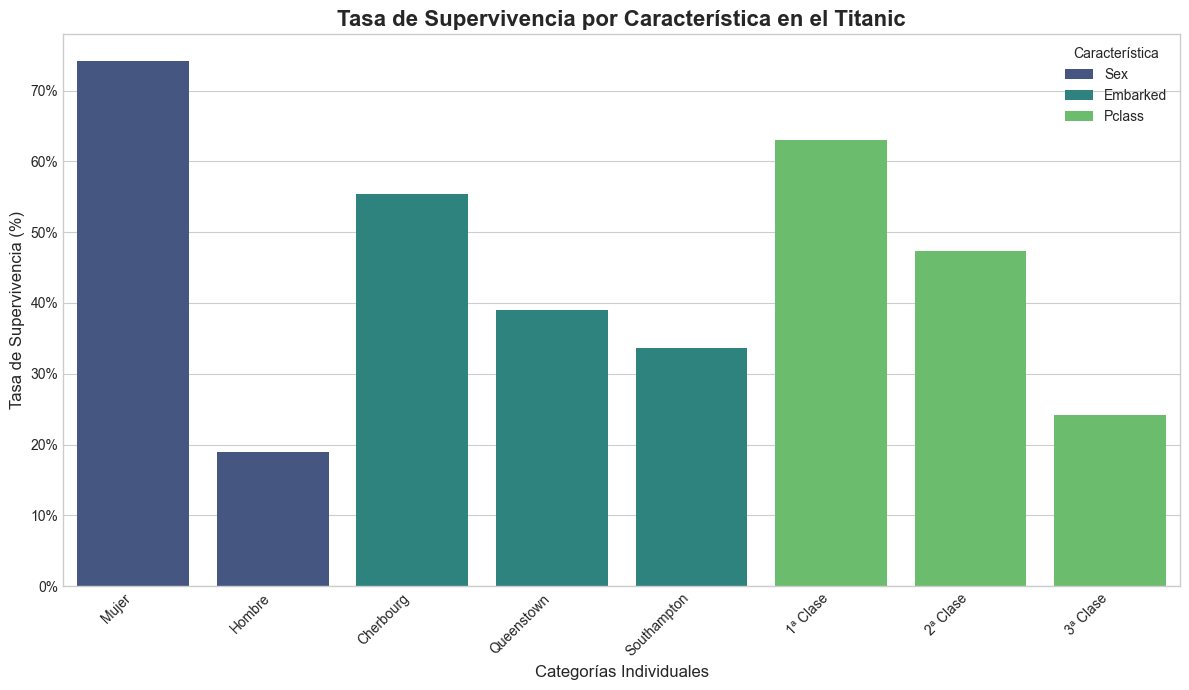

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

df=pd.read_csv('titanictrain.csv')


# 1. Preparar los datos para el gráfico combinado
features_to_plot = ['Sex', 'Embarked', 'Pclass']
all_survival_data = []

for feature in features_to_plot:
    # Calcular la tasa de supervivencia para la característica actual
    survival_rate = df.groupby(feature)['Survived'].mean().reset_index()
    
    # Renombrar columnas para unificar el formato
    survival_rate.columns = ['Category', 'Survival_Rate']
    
    # Añadir una columna que identifique la característica principal (para el color)
    survival_rate['Feature'] = feature
    
    # Añadir estos datos a nuestra lista
    all_survival_data.append(survival_rate)

# Concatenar todos los dataframes en uno solo
combined_df = pd.concat(all_survival_data, ignore_index=True)

# Convertir la tasa de supervivencia a porcentaje
combined_df['Survival_Rate'] *= 100

# 2. Crear el gráfico
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Usamos 'Category' en el eje X y coloreamos por 'Feature'
sns.barplot(
    data=combined_df,
    x='Category',
    y='Survival_Rate',
    hue='Feature',
    palette='viridis',
    dodge=False,  # Importante: para que no intente agrupar las barras
    ax=ax
)

# 3. Personalizar y mejorar el gráfico
ax.set_title('Tasa de Supervivencia por Característica en el Titanic', fontsize=16, weight='bold')
ax.set_xlabel('Categorías Individuales', fontsize=12)
ax.set_ylabel('Tasa de Supervivencia (%)', fontsize=12)

# Formatear el eje Y para mostrar el símbolo de porcentaje
ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))

# Mejorar la leyenda
legend = ax.get_legend()
legend.set_title("Característica")

# Ajustar las etiquetas del eje X para mayor claridad
# Creamos etiquetas más descriptivas para que el usuario entienda cada barra
new_labels = {
    'male': 'Hombre', 'female': 'Mujer',
    'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown',
    1: '1ª Clase', 2: '2ª Clase', 3: '3ª Clase'
}
# Obtenemos las etiquetas actuales y las reemplazamos si están en nuestro diccionario
current_labels = [item.get_text() for item in ax.get_xticklabels()]
updated_labels = [new_labels.get(label, label) for label in current_labels]

# Intentamos convertir las etiquetas numéricas de clase a int antes de buscar
try:
    current_labels_int = [int(float(label)) if label.replace('.', '', 1).isdigit() else label for label in current_labels]
    updated_labels = [new_labels.get(label, label) for label in current_labels_int]
except ValueError:
    pass # Se mantiene la versión anterior si la conversión falla

ax.set_xticklabels(updated_labels, rotation=45, ha="right")

# 4. Mostrar el gráfico
plt.tight_layout()
plt.show()

Generando Gráfico 1: Tasa de Supervivencia por Sexo y Clase...


C:\Users\iraze\AppData\Local\Temp\ipykernel_4412\4123299030.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['1ª Clase', '2ª Clase', '3ª Clase'])


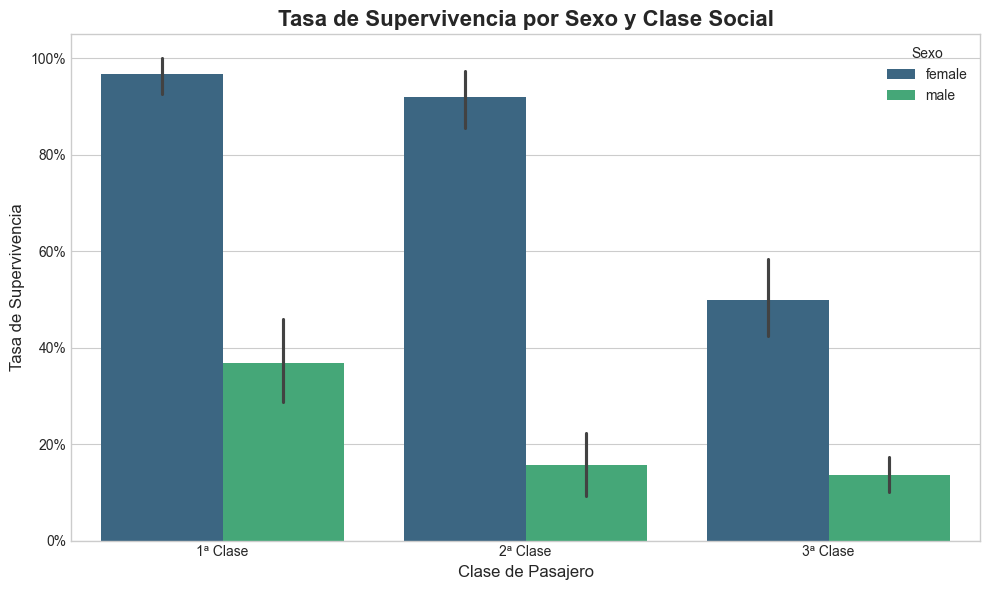


Generando Gráfico 2: Distribución de Edad por Supervivencia...


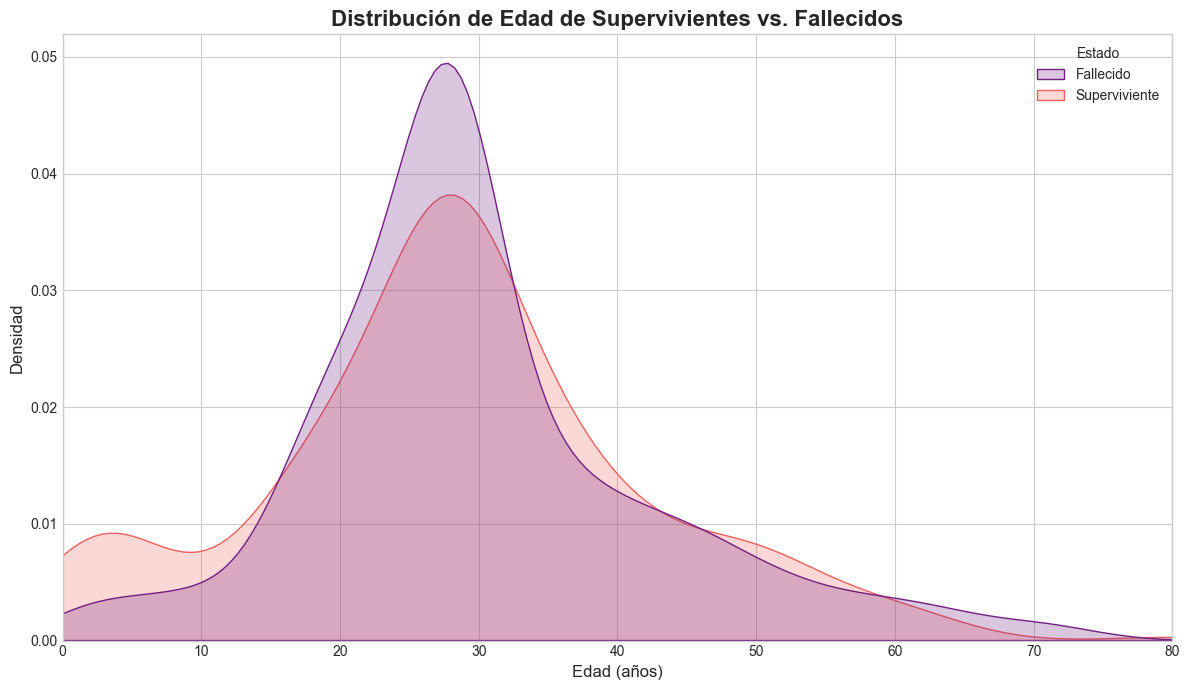

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter



# Establecer un estilo visual para los gráficos
plt.style.use('seaborn-v0_8-whitegrid')


# --- GRÁFICO 1: Interacción entre Sexo y Clase ---
print("Generando Gráfico 1: Tasa de Supervivencia por Sexo y Clase...")

# Crear una figura y un eje para el primer gráfico
fig1, ax1 = plt.subplots(figsize=(10, 6))

# Usar seaborn.barplot es ideal para este tipo de gráfico agrupado
sns.barplot(
    data=df,
    x='Pclass',
    y='Survived',
    hue='Sex',
    palette='viridis',
    ax=ax1
)

# Personalización del gráfico 1
ax1.set_title('Tasa de Supervivencia por Sexo y Clase Social', fontsize=16, weight='bold')
ax1.set_xlabel('Clase de Pasajero', fontsize=12)
ax1.set_ylabel('Tasa de Supervivencia', fontsize=12)

# Formatear el eje Y como porcentaje
ax1.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=0))

# Ajustar las etiquetas del eje X para que sean más descriptivas
ax1.set_xticklabels(['1ª Clase', '2ª Clase', '3ª Clase'])

# Mejorar la leyenda
ax1.legend(title='Sexo')

# Mostrar el primer gráfico
plt.tight_layout()
plt.show()


# --- GRÁFICO 2: Distribución de Edad por Supervivencia ---
print("\nGenerando Gráfico 2: Distribución de Edad por Supervivencia...")

# Preprocesamiento: Rellenar edades faltantes con la mediana para poder graficar
# Es una estrategia simple pero efectiva para la visualización.
df['Age'].fillna(df['Age'].median(), inplace=True)

# Crear una figura y un eje para el segundo gráfico
fig2, ax2 = plt.subplots(figsize=(12, 7))

# Usar seaborn.kdeplot con 'hue' para separar las distribuciones por supervivencia
# El argumento 'fill=True' crea un área sombreada que facilita la visualización
sns.kdeplot(
    data=df,
    x='Age',
    hue='Survived',
    fill=True,
    common_norm=False, # Cada curva se normaliza independientemente
    palette='magma',
    ax=ax2
)

# Personalización del gráfico 2
ax2.set_title('Distribución de Edad de Supervivientes vs. Fallecidos', fontsize=16, weight='bold')
ax2.set_xlabel('Edad (años)', fontsize=12)
ax2.set_ylabel('Densidad', fontsize=12)
ax2.set_xlim(0, df['Age'].max()) # Empezar el eje X en 0

# Mejorar la leyenda
# Obtenemos la leyenda actual y cambiamos los títulos
legend = ax2.get_legend()
legend.set_title('Estado')
# Los valores de 'Survived' son 0 y 1, los reemplazamos por etiquetas claras
if len(legend.texts) == 2:
    legend.texts[0].set_text('Fallecido')
    legend.texts[1].set_text('Superviviente')

# Mostrar el segundo gráfico
plt.tight_layout()
plt.show()

### 5. Generación de la Sumisión para Kaggle
Finalmente, utilizamos el modelo entrenado para hacer predicciones sobre el set de test y generamos el archivo `submission.csv`.

In [ ]:
# Hacemos las predicciones en el conjunto de test
predictions = model.predict(X_test)

# Creamos el DataFrame para la sumisión
submission_df = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predictions
})

# Guardamos el archivo en formato CSV
submission_df.to_csv('submission.csv', index=False)

print("Archivo 'submission.csv' generado con éxito.")
submission_df.head()